# Dataset generation and introduction to word embeddings

This notebook contains the code to generate vector embeddings from the descriptions of the movies in the dataset. The code is accompanied by a short introduction to what a vector embedding is, in case you needed a refresher. For a more step-by-step introduction, you can take a look at the [workshop we gave last year](https://github.com/xtreamsrl/movies-buddy). Marqo has another great series of [in-depth tutorials](https://www.marqo.ai/courses/) about embeddings, vector search and RAG.

We use [Polars](https://pola.rs/) as our data manipulation library, and [LanceDB](https://lancedb.github.io/lancedb/) as the vector storage.

In [ ]:
import importlib

import polars as pl

if not importlib.util.find_spec("lancedb"):
    !pip install -qqq lancedb

## Fetch the original dataset

The movies dataset comes from [Kaggle](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots). The dataset was downloaded by hand, but you can also use the official client, [`kagglehub`](https://github.com/Kaggle/kagglehub).

In [ ]:
movies_data = pl.read_parquet("https://raw.githubusercontent.com/xtreamsrl/beyond-the-hype/main/data/movies_plots_dataset.parquet").rename(
    {
        "Release Year": "release_year",
        "Title": "title",
        "Origin/Ethnicity": "origin",
        "Director": "director",
        "Cast": "cast",
        "Genre": "genre",
        "Wiki Page": "wiki_page",
        "Plot": "plot",
    }
)

In [ ]:
movies_data.head()

The dataset has a `Plot` column, which summarises the movie's contents. There are, however, other dimensions to this dataset: the year of its release (ranging from 1901 to 2017), its title, director, genre, the country/area where it was produced and the Wikipedia page where the summary was taken from.

In [ ]:
movies_data.describe()

## Generate the embeddings

### What's an embedding?

To perform any computational task on unstructured data, like text, we need to convert it to a numerical representation. For this, we use embedding models.

In short, these models are neural networks that are trained on huge amounts of raw data to build a "mental map" of where concepts lie - in other words, the model "learns" to cluster together words that are similar, such as "cat" and "kitten". You can find more about embeddings on the [Wikipedia page](https://en.wikipedia.org/wiki/Word_embedding), the [original paper](https://arxiv.org/abs/1301.3781) or a visual explanation [here](https://jalammar.github.io/illustrated-word2vec/).

The goal behind this transformation is that, once we have converted words or entire sentences into vectors, we can compare them. Take a look at the picture below: if you squint a little, you might notice that the vectors for `woman` and `girl` look more similar than `boy` and `man`, and all of the words' representation are very distant from `water`.

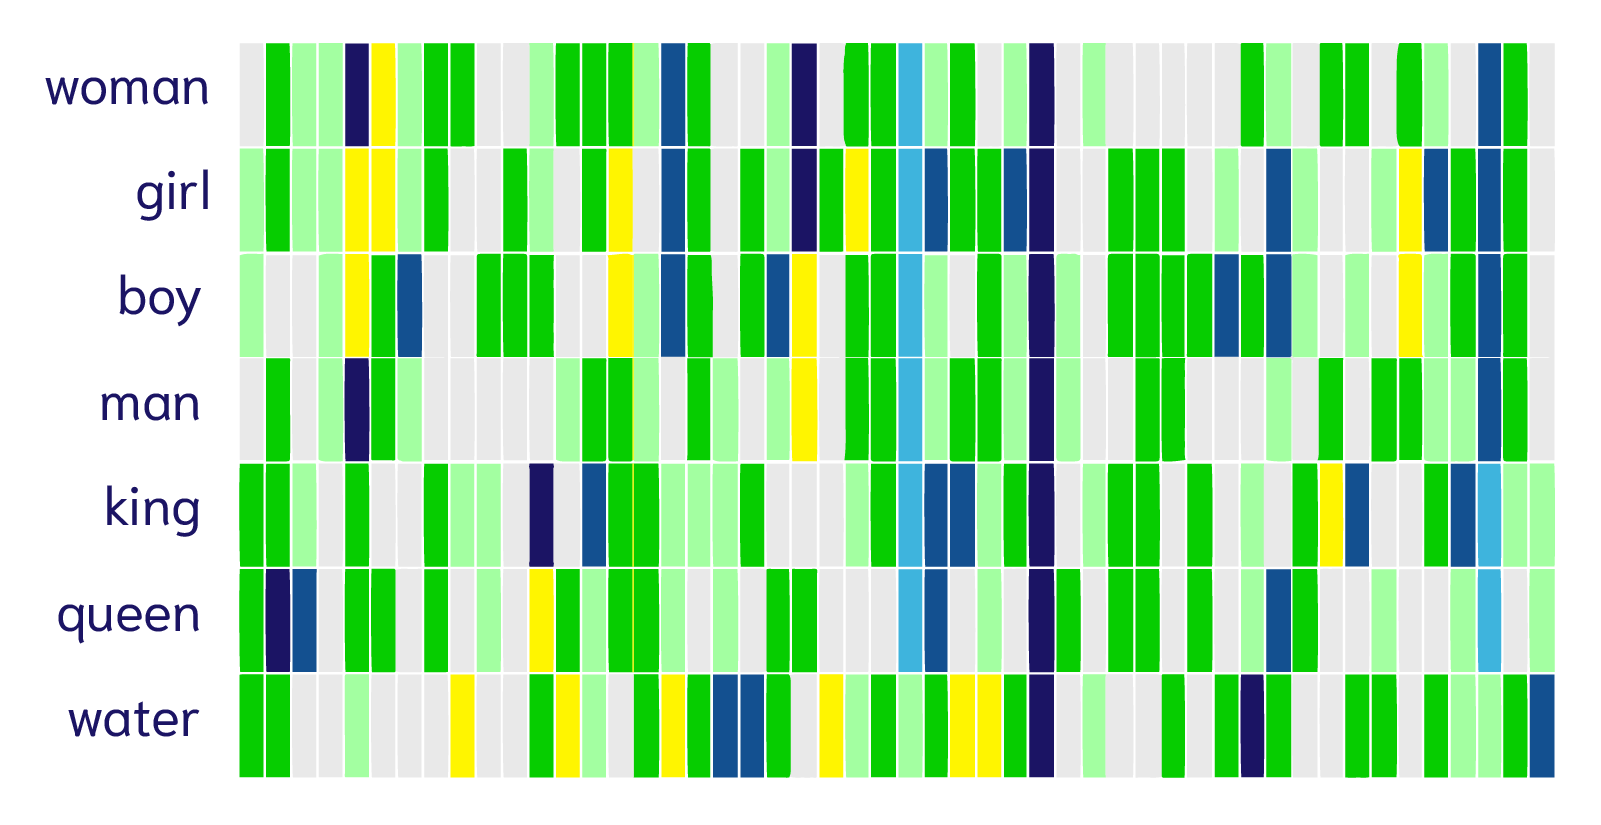

[*source*](https://weaviate.io/blog/vector-embeddings-explained)

Of course, you can think of these numerical representations as coordinates in space. This allows you to display the vectors in space:

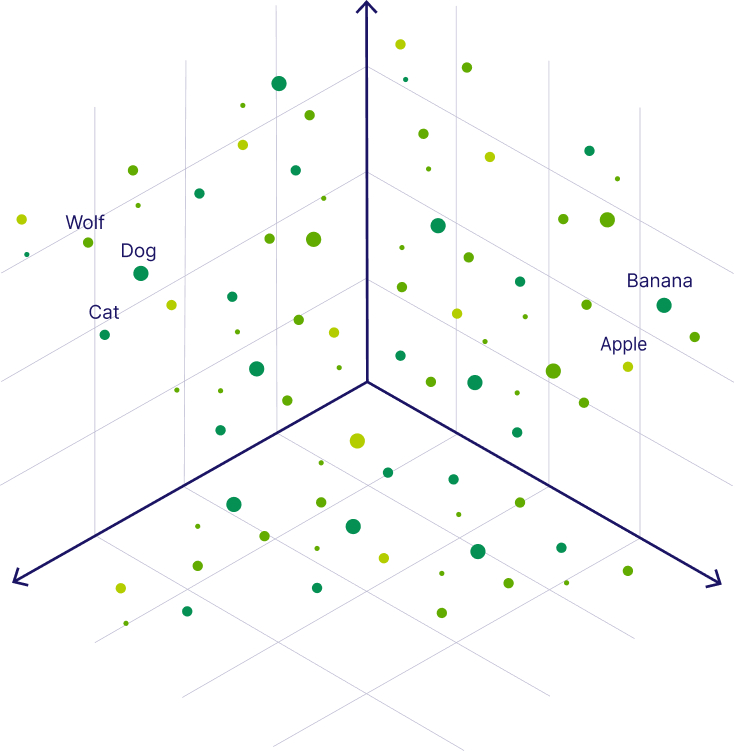

[*source*](https://weaviate.io/blog/vector-embeddings-explained)

### Choice of the embedding model

We use [MiniLM](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) to encode the movies' plot. MiniLM is a popular, BERT-based model ([paper](https://arxiv.org/abs/2002.10957)). While not the top-performing model on the [leaderboards](https://huggingface.co/spaces/mteb/leaderboard), it's still a great contender - especially when it comes to the size. In fact, MiniLM is quite small and produces vectors of size 384.

You might want to pick your embedding model differently, but for our purposes it does just what we want.

In [ ]:
from sentence_transformers import SentenceTransformer

encoder = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
encoder

From the string representation of the object, we can see that our encoder model handles sequences of length 256 and outputs embeddings of size 384.

To be more precise, the model:

1. Tokenizes the input sequence.
2. Computes the embeddings for every token.
3. Pools the vectors to obtain the final vector that will represent the sentence.

Confused? Don't worry, we're breaking this down.

Tokenisation is simply how a model maps (subset of) words from a sentence into its internal "vocabulary". We can see the tokens that make up a query like this:

In [ ]:
query = "Star Wars"

encoded_tokens = encoder.tokenize([query])["input_ids"]

encoded_tokens

Then, for each token, the model generates an embedding - i.e., the numerical vector. To compute the vector, the model uses the tokens that come before and after the target token.

Each model can have a different tokenizer (i.e. vocabulary). You can explore how different models might encode sentences in different ways from this [webapp](https://huggingface.co/spaces/Xenova/the-tokenizer-playground). In general, the first and last tokens are "special" tokens that mark the beginning and end of a sentence.

Once we have an embedding for every token, the model *pools* them - simply put, aggregates every vector to have only one vector to represent the sentence. In our case, MiniLM will compute the average across all vectors, to encode the query.

We don't have to do this for ourselves: if we call the `encode()` method of the encoder, it will do everything for us all at once.

In [ ]:
encoded_query = encoder.encode(query)

encoded_query

Notice how the encoded query is only 1 vector of size 384:

In [ ]:
encoded_query.shape

### Compute the emebddings of the movies' plot

Now it's time to process the whole dataset. It might take some time - especially if you run it on Colab - so grab a cup of tea.

In [ ]:
plot_vectors = encoder.encode(movies_data["plot"].to_numpy())

In [ ]:
movies_data = movies_data.with_columns(pl.Series(name="vector", values=plot_vectors))

Then, we save the output to the parent directory, in a new folder named `data`.

In [ ]:
from pathlib import Path

data_path = Path.cwd().parent / "data"

if not data_path.exists():
    data_path.mkdir()

movies_data.write_parquet(f"{data_path}/movies_plots_dataset_embd_minilm.parquet")

## Create a vector storage

Now we have the vectors - what do we use them for? In short, we use them for similarity search.

Unlike traditional search that relies on exact matches, vector search looks for similarity based on meaning or context. It's used in applications like image retrieval, recommendation systems, and search engines. You can read more about it [here](https://weaviate.io/blog/vector-search-explained). How is search performed? In a nutshell, we need two ingredients:

1. A [distance metric](https://weaviate.io/blog/distance-metrics-in-vector-search), like the Euclidean distance.
2. A search algorithm.

There are a lot of search algorithm - though you will likely know one for sure: [k-nearest neighbours](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), or KNN. It's the most accurate, but becomes slow as the number of vectors increses (100k+). For this reason, vector database implement *approximate nearest neighbour* (ANN) algorithms, that trade some accuracy for speed. In other words, they might not return the closest results to the query vector, but will do it much faster.

We chose `lancedb` as our vector database. That's because it's in-process, like sqlite, and makes it really easy to store the data.

In [ ]:
import lancedb

uri = f"{data_path}/movies_embeddings"
db = lancedb.connect(uri)

In [ ]:
movies_table = db.create_table("movies", movies_data, exist_ok=True)

We then create the indexes to perform the search. lancedb is capable both of "traditional" search (exact match, or *full text search*) and semantic search, so we will create indexes for each:

In [ ]:
# create an index using cosine similarity for semantic search
movies_table.create_index("cosine")

# create full-text indexes for exact search
movies_table.create_fts_index("title", use_tantivy=False)
movies_table.create_fts_index("cast", use_tantivy=False)

The purpose of this database is to perform semantic search. For example, say we want to search for all the movies that have `star wars` in the title:

In [ ]:
(
    movies_table
    # this kinda looks like SQL!
    .search("star wars", query_type="fts")
    .limit(10)
    .select(["title", "director", "plot"])
    .to_polars()
)

Fairly easy, right? The `_score` column tells us which are the most likely results. We might be disappointed that `Rogue One` scored so low, below matches that aren't appropriate. Could semantic search this? It might, but there's one thing that semantic search might help us with.

Suppose we make a mistake:

The results are plausible enough for us to be satisfied. However, what if we make a typo?

In [ ]:
(
    movies_table
    # can you see the error?
    .search("star wras", query_type="fts")
    .limit(10)
    .select(["title", "director", "plot"])
    .to_polars()
)

The results don't make sense anymore! Instead, what if we use semantic search, with our query vector?

In [ ]:
encoded_query = encoder.encode("Star Wars")

(
    movies_table
    # this kinda looks like SQL!
    .search(encoded_query)
    .limit(10)
    .select(["title", "director", "plot"])
    .to_polars()
)

This does not look great either. But it makes sense: we should not be using semantic search with keywords that are basically only useful for keyword search.

In [ ]:
encoded_query = encoder.encode(
    "Rebel forces stole the plans for a mass destruction weapon the size of a planet"
)

(
    movies_table
    # note we changed the query type
    .search(encoded_query, query_type="vector")
    .limit(10)
    .select(["title", "director", "plot"])
    .to_polars()
)

Are the results correct? Well, it depends. But you do start to see that - if I input a description of a movie that I liked - the semantic search will return movies that have a similar plot (at least according to the model we used to encode them).

Finally, we should not forget we can perform a search that's a combination of the two: it's called *hybrid*.

In [ ]:
encoded_query = encoder.encode(
    "Rebel forces stole the plans for a mass destruction weapon the size of a planet"
)
query = "Star Wars"

(
    movies_table
    # note we changed the query type
    .search(query_type="hybrid")
    .vector(encoded_query)
    .text(query)
    .limit(20)
    .select(["title", "director", "plot"])
    .to_polars()
)

What are the differences in the results of vector search and full-text search?

Note that we still get movies that don't have `Star Wars` in the title, though they appear lower in the rankings. This could become powerful if we could find a way to automate the extraction of keywords from the query... *foreshadowing*